In [1]:
import logging
import time

import numpy as np
from joblib import hash, dump, load
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sys
print(os.path.abspath(''))
from os import path
sys.path.append( path.abspath(os.path.abspath('')) ) 
print(path.abspath(os.path.abspath('')) )


from microGrid.env.final_env import MyEnv as MG_two_storages_env
import microGrid.experiment.base_controllers as bc
from datetime import datetime
from microGrid.plot_MG_operation import plot_op
import tensorflow as tf
import pandas as pd
from stable_baselines3 import DQN

/home/ubuntu/WorkSpace/M2/STAGE
/home/ubuntu/WorkSpace/M2/STAGE


ModuleNotFoundError: No module named 'microGrid'

In [2]:
import csv 

def read_csv(f, sep=";"):
    f = open(f)
    res = None
    csv_file = csv.reader(f, delimiter=sep)
    for l in csv_file:
        if res is None:
            res= [[] for _ in l]
        for i in range(len(l)):
            res[i].append(l[i])
    return res


In [3]:
file_parse = read_csv('data/conso-region-occitanie-2019-demi-hv0.csv')


In [7]:
np.array(file_parse)[:,0]

array(['Horodate', 'Région', 'Code région', 'Profil',
       'Plage de puissance souscrite', 'Secteur activité',
       'Nb points soutirage', 'Total énergie soutirée (Wh)',
       'Courbe Moyenne n°1 (Wh)',
       'Indice représentativité Courbe n°1 (%)',
       'Courbe Moyenne n°2 (Wh)',
       'Indice représentativité Courbe n°2 (%)',
       'Courbe Moyenne n°1 + n°2 (Wh)',
       'Indice représentativité Courbe n°1 + n°2 (%)',
       'Jour max du mois (0/1)', 'Semaine max du mois (0/1)'],
      dtype='<U44')

Horodate | Total énergie soutirée (Wh)


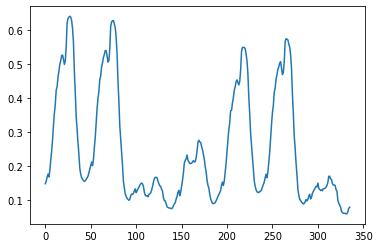

In [35]:
print(file_parse[0][0],"|",file_parse[7][0])
def cumul_data(mat_csv, column_need, column_uniqu=None, head=False):
    res = []
    uniqu = dict()
    for i, val in enumerate(mat_csv[column_need]):
        if not bool(val.strip()):
            continue
        if head:
            head = False
            continue
        if column_uniqu is None:
            res.append(float(val))
        elif mat_csv[column_uniqu][i] in uniqu:
            res[uniqu[mat_csv[column_uniqu][i]]] += float(val)
        else:
            uniqu[mat_csv[column_uniqu][i]] = len(res)
            res.append(float(val))
    return res
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
res = cumul_data(file_parse, 7, 0, head=True)
plt.plot(scaler.fit_transform(np.array(res).reshape(-1,1))[0:7*24*2])

In [ ]:
print("tensorflow work with:", tf.test.gpu_device_name())
logging.basicConfig(level=logging.INFO)
rng = np.random.RandomState()

In [3]:
class Defaults:
    # ----------------------
    # Experiment Parameters
    # ----------------------
    STEPS_PER_EPOCH = 365*24-1
    EPOCHS = 200
    STEPS_PER_TEST = 365*24-1
    PERIOD_BTW_SUMMARY_PERFS = -1  # Set to -1 for avoiding call to env.summarizePerformance
    
    # ----------------------
    # Environment Parameters
    # ----------------------
    FRAME_SKIP = 1

    # ----------------------
    # DQN Agent parameters:
    # ----------------------
    UPDATE_RULE = 'rmsprop'
    LEARNING_RATE = 0.02
    LEARNING_RATE_DECAY = 0.99
    DISCOUNT = 0.99
    DISCOUNT_INC = 0.99
    DISCOUNT_MAX = 0.98
    RMS_DECAY = 0.9
    RMS_EPSILON = 0.0001
    MOMENTUM = 0
    CLIP_NORM = 1.0
    EPSILON_START = 1.0
    EPSILON_MIN = .1
    EPSILON_DECAY = 2.3e-5
    UPDATE_FREQUENCY = 1
    REPLAY_MEMORY_SIZE = 1000000
    BATCH_SIZE = 32
    FREEZE_INTERVAL = 1000
    DETERMINISTIC = False


In [4]:
# --- Instantiate reward_function ---
price_h2 = 0.1  # 0.1euro/kWh of hydrogen
price_elec_buy = 2.0  # 2euro/kWh

In [5]:
# --- Instantiate environment ---
pred = 0
equinox = 1
dict_env = dict()

env = MG_two_storages_env(rng, pred = pred, dist_equinox =equinox)
absolute_dir = os.path.abspath('')
prod = np.load(absolute_dir + "/microGrid/env/data/BelgiumPV_prod_test.npy")[0:1 * 365 * 24]
cons = np.load(absolute_dir + "/microGrid/env/data/example_nondeterminist_cons_test.npy")[0:1 * 365 * 24]
env_valid = MG_two_storages_env(rng, consumption=cons, production=prod, pred = pred, dist_equinox =equinox)

# optimisation énergie
env_ener = MG_two_storages_env(rng, consumption=cons, production=prod, pred = pred, dist_equinox =equinox)
dict_env["energy"] = env_ener
# ressenti client
env_user= MG_two_storages_env(rng, consumption=cons, production=prod, pred = pred, dist_equinox =equinox)
dict_env["user"] = env_user
# profit réseau 
env_profit = MG_two_storages_env(rng, consumption=cons, production=prod, pred = pred, dist_equinox =equinox)
dict_env["profit"] = env_profit
#préservation des stockages 
env_stockage = MG_two_storages_env(rng, consumption=cons, production=prod, pred = pred, dist_equinox =equinox)
dict_env["stockage"] = env_stockage

reduce_qty_data, length_history, start_history
1 12 0
Sample of the consumption profile (kW): [4.88090280e-05 4.08636652e-04 2.66459683e-03 1.35325348e-02
 5.35289841e-02 1.64925998e-01 3.95869422e-01 7.40576948e-01
 1.08118010e+00 1.23674331e+00 1.12378457e+00 8.51875992e-01
 6.28731540e-01 5.94891051e-01 7.62627204e-01 1.05973501e+00
 1.38386090e+00 1.63210044e+00 1.72495565e+00 1.63169652e+00
 1.38119778e+00 1.04620892e+00 7.09130415e-01 4.30109338e-01]
Min of the consumption profile (kW): 3.569456443385281e-05
Max of the consumption profile (kW): 2.1
Average consumption per day train (kWh): 18.56458726184315
self.production_train brefore
[0. 0. 0. ... 0. 0. 0.]
self.production_train after
[0. 0. 0. ... 0. 0. 0.]
Sample of the production profile (kW): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00225469 0.01691014 0.
 0.         0.         0.         0.         0.         0.

C:\WorkSpace\code\venv\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [6]:
env.add_reward("flow_h2", lambda x: x["flow_H2"] * price_h2, 1.)
env.add_reward("buy_energy", lambda x: -x["lack_energy"] * price_elec_buy, 1.)

In [7]:
env_valid.add_reward("flow_h2", lambda x: x["flow_H2"] * price_h2, 1.)
env_valid.add_reward("buy_energy", lambda x: -x["lack_energy"] * price_elec_buy, 1.)

In [8]:
cost_wast = 0.1 #(valeur arbitraire)
dict_env["energy"].add_reward("waste", lambda x: -x["waste_energy"] * cost_wast, 1.)
dict_env["profit"].add_reward("profit", lambda x: (x["waste_energy"]-x["lack_energy"]) * price_elec_buy, 1.)

In [9]:
print('MlpPolicy', 
            "learning_rate=",Defaults.LEARNING_RATE, 
            "buffer_size=",Defaults.REPLAY_MEMORY_SIZE, 
            "batch_size=",Defaults.BATCH_SIZE, 
            "gamma=",Defaults.DISCOUNT,
            "exploration_initial_eps=",Defaults.EPSILON_START,
            "exploration_final_eps=",Defaults.EPSILON_MIN,
            "exploration_fraction=",Defaults.EPSILON_DECAY,sep='\n')
print(len(env.observation_space.sample()))
print(len(env.reset()))
model = DQN('MlpPolicy', env, 
            learning_rate=Defaults.LEARNING_RATE, 
            buffer_size=Defaults.REPLAY_MEMORY_SIZE, 
            batch_size=Defaults.BATCH_SIZE, 
            gamma=Defaults.DISCOUNT,
            exploration_initial_eps=Defaults.EPSILON_START,
            exploration_final_eps=Defaults.EPSILON_MIN,
            exploration_fraction=Defaults.EPSILON_DECAY,
            verbose=1)

MlpPolicy
learning_rate=
0.02
buffer_size=
1000000
batch_size=
32
gamma=
0.99
exploration_initial_eps=
1.0
exploration_final_eps=
0.1
exploration_fraction=
2.3e-05
26
26
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from collections import defaultdict
    

class BestCallback(BaseCallback):
    def __init__(self, valid_env, dict_env, patience, dirname, parent_path):
        super().__init__()
        self.validationScores = defaultdict(list)
        self.trainScores = []
        self.dict_env = dict_env
        self.env_valid = valid_env
        self.bestValidationScoreSoFar = None
        self.cycle = 0
        self.patience = patience
        self.dirname = dirname
        self.parent_path = parent_path
        self.data = None
    
        
    def _on_step(self) -> bool:
        if not all(self.locals["dones"]):
            return True
        self.cycle += 1
        
        
        for k in self.dict_env.keys():
            mean_reward, std_reward = evaluate_policy(self.model, self.dict_env[k], n_eval_episodes=1)
            self.validationScores[k].append(mean_reward)

        mean_reward, std_reward = evaluate_policy(self.model, self.env_valid, n_eval_episodes=1)
        self.validationScores["default"].append(mean_reward)
        mean_reward, std_reward = evaluate_policy(self.model, self.training_env, n_eval_episodes=1)
        self.trainScores.append(mean_reward)
        
        # part best
        if self.bestValidationScoreSoFar is None or self.validationScores["default"][-1] > self.bestValidationScoreSoFar:
            self.cycle = 0
            self.bestValidationScoreSoFar = self.validationScores["default"][-1]
            print("new best", self.dirname + "score:"+ str(self.validationScores["default"][-1]))
            print("train score:"+ str(self.trainScores[-1]))
            self.model.save(self.parent_path + "/" + self.dirname + "/" + self.dirname + 
                            "-score-" + str(self.validationScores["default"][-1]))
            self.data = self.env_valid.get_data()[-2] #-1 empty because env is reset at the end
            #agent.dumpNetwork(self.dirname + "/" + self.dirname + "-score-" + str(validationScores["default"][-1]), epoch)
        if self.cycle >= self.patience:
            return False
        return True
    def get_data(self):
        return self.data
    def get_score(self):
        return self.validationScores, self.trainScores
    

In [11]:
import time
now = datetime.now()
# dd_mm_YY-H-M-S
dt_string = now.strftime("%d_%m_%Y-%H-%M-%S")
dirname = "result"
filename = "best" + dt_string
best=  BestCallback(env_valid, dict_env, 30, filename, dirname)
start = time.time()
model.learn(Defaults.EPOCHS * Defaults.STEPS_PER_EPOCH, callback=best)#callback=[verbose_callback, eps_callback, best_callback]
res = time.time() - start
print("time:", int(res /3600),"h", int((res % 3600)/60),"min", res % 60, "s")

C:\WorkSpace\code\venv\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


new best best26_04_2022-08-38-34score:-2874.808621198965
train score:-3475.953387


C:\WorkSpace\code\venv\lib\site-packages\stable_baselines3\common\save_util.py:276: UserWarning: Path 'result\best26_04_2022-08-38-34' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 8.76e+03  |
|    ep_rew_mean      | -9.69e+03 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 4         |
|    fps              | 504       |
|    time_elapsed     | 69        |
|    total_timesteps  | 35036     |
-----------------------------------
new best best26_04_2022-08-38-34score:-2608.809119839845
train score:-3066.251564
new best best26_04_2022-08-38-34score:-2275.3897842552087
train score:-2689.508798
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 8.76e+03  |
|    ep_rew_mean      | -7.97e+03 |
|    exploration_rate | 0.1       |
| time/               |           |
|    episodes         | 8         |
|    fps              | 463       |
|    time_elapsed     | 151       |
|    total_timesteps  | 70072     |
| train/              |           |
|    learning_rate    | 0.02      |
|    lo

dict_keys(['action', 'battery', 'rewards', 'consumption', 'production', 'battery_h2', 'flow_H2', 'lack_energy', 'waste_energy', 'flow_h2', 'buy_energy'])
In this plot, total score-103.29703473592393


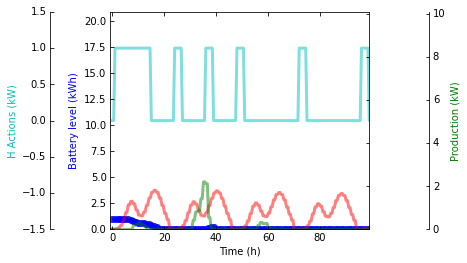

In this plot, total score2.0900000000000003


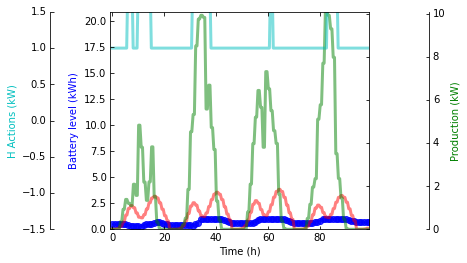

In this plot, total score-16.469458533997937


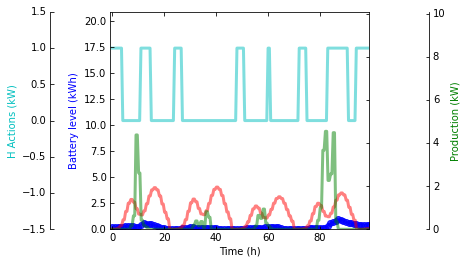

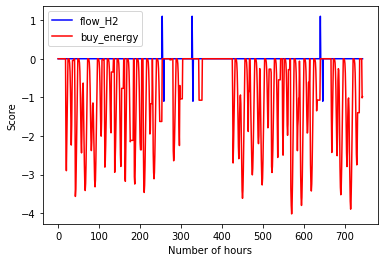

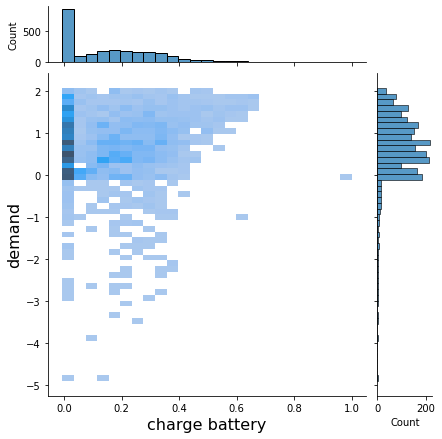

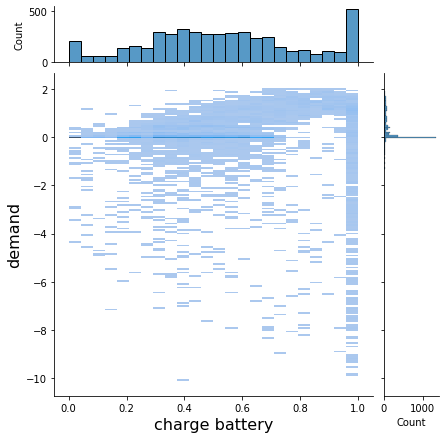

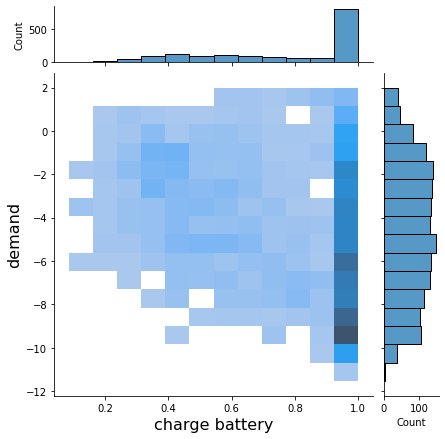

demande moyenne :  -0.7289690599108651
demande std :  2.602111036990436


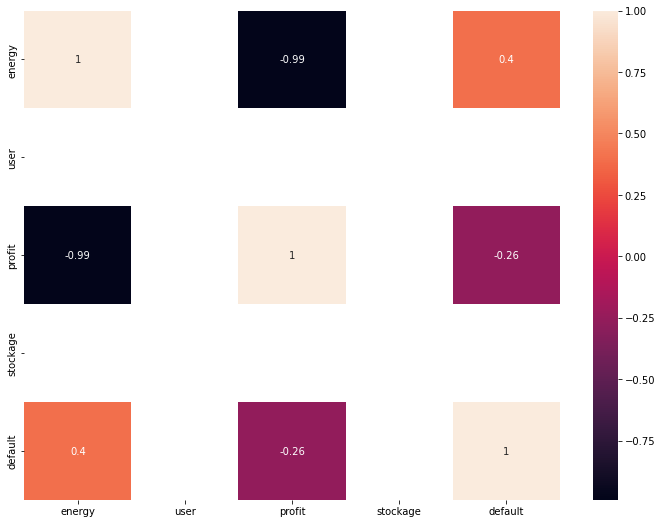

reward -1256.7167403403967


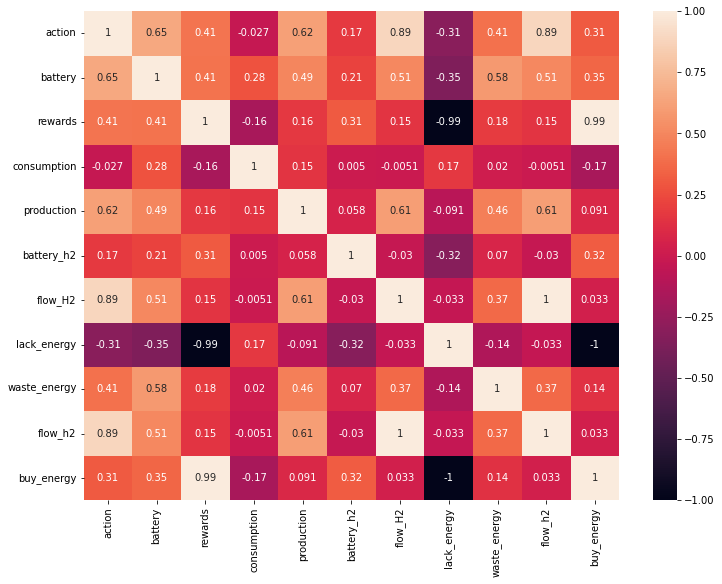

reward -1256.7167403403967


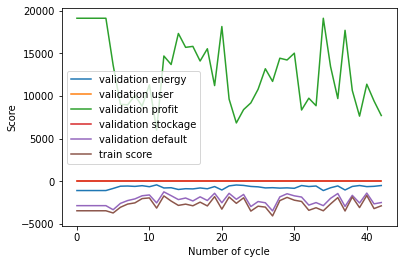

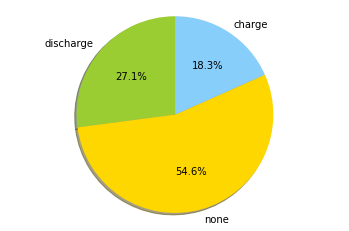

In [13]:
data = best.get_data()
validationScores, trainScores = best.get_score()
print(data.keys())

actions= data["action"]
consumption = data["consumption"]
production = data["production"]
rewards = data["rewards"]
battery_level= data["battery"]
#plot_op(data["action"], data["consumption"], data["production"], data["rewards"], data["battery"], "test.png")
i = 0
plot_op(actions[0+i:100+i],consumption[0+i:100+i],production[0+i:100+i],rewards[0+i:100+i],battery_level[0+i:100+i],"testplot_winter_.png")
plt.show()
i=180*24
plot_op(actions[0+i:100+i],consumption[0+i:100+i],production[0+i:100+i],rewards[0+i:100+i],battery_level[0+i:100+i],"testplot_summer_.png")
plt.show()
i=360*24
plot_op(actions[0+i:100+i],consumption[0+i:100+i],production[0+i:100+i],rewards[0+i:100+i],battery_level[0+i:100+i],"testplot_winter2_.png")
plt.show()

key = "flow_H2"
plt.plot(range(31*24), data[key][:31*24], label=key, color='b')
key = "buy_energy"
plt.plot(range(31*24), data[key][:31*24], label=key, color='r')

plt.legend()
plt.xlabel("Number of hours")
plt.ylabel("Score")
plt.savefig(dirname + "/" + filename + "_plots.pdf")
plt.show()

h = sns.jointplot(x=[battery_level[i] for i in range(len(actions)) if actions[i] == 0],
                  y=[consumption[i] - production[i] for i in range(len(actions)) if actions[i] == 0],
                  kind="hist", marginal_ticks=True)
# JointGrid has a convenience function
h.set_axis_labels('charge battery', 'demand', fontsize=16)
plt.savefig(dirname + "/" + filename + "_plots_action0.pdf")
plt.show()

h = sns.jointplot(x=[battery_level[i] for i in range(len(actions)) if actions[i] == 1],
                  y=[consumption[i] - production[i] for i in range(len(actions)) if actions[i] == 1],
                  kind="hist", marginal_ticks=True)
# JointGrid has a convenience function
h.set_axis_labels('charge battery', 'demand', fontsize=16)
plt.savefig(dirname + "/" + filename + "_plots_action1.pdf")
plt.show()

h = sns.jointplot(x=[battery_level[i] for i in range(len(actions)) if actions[i] == 2],
                  y=[consumption[i] - production[i] for i in range(len(actions)) if actions[i] == 2],
                  kind="hist", marginal_ticks=True)
# JointGrid has a convenience function
h.set_axis_labels('charge battery', 'demand', fontsize=16)
plt.savefig(dirname + "/" + filename + "_plots_action2.pdf")
plt.show()

demande = [consumption[i] - production[i] for i in range(len(actions))]
print("demande moyenne : ", np.mean(demande))
print("demande std : ", np.std(demande))



corr = pd.DataFrame.from_dict(validationScores)
corr = corr.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corr, annot = True)
#plt.savefig(dirname + "/" + filename + "_heatmap.pdf")
plt.show()
print("reward", np.sum(data["rewards"]))


corr = pd.DataFrame.from_dict(data)
corr = corr.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corr, annot = True)
plt.savefig(dirname + "/" + filename + "_heatmap.pdf")
plt.show()
print("reward", np.sum(data["rewards"]))

for k in validationScores.keys():
    plt.plot(range(len(validationScores[k])), validationScores[k], label="validation "+ str(k))
plt.plot(range(len(trainScores)), trainScores, label="train score")
#plt.plot(x, np.repeat(testScores, nb_rep), label="TS", color='r')
plt.legend()
plt.xlabel("Number of cycle")
plt.ylabel("Score")
plt.savefig(dirname + "/" + filename + "_scores.pdf")
plt.show()


labels = 'discharge', 'none', 'charge'
sizes = [len([1 for i in range(len(actions)) if actions[i] == 0]), 
         len([1 for i in range(len(actions)) if actions[i] == 1]),
         len([1 for i in range(len(actions)) if actions[i] == 2])]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')

#plt.savefig('PieChart01.png')
plt.show()
